In [1]:
import pickle
import time
from datetime import date
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from tensorflow.keras import regularizers, layers
from sklearn.model_selection import train_test_split
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard


2023-11-02 20:48:33.015200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 20:48:33.015254: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 20:48:33.015274: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 20:48:33.023307: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 20:48:33.879765: W tensorflow/compiler/

In [2]:
devices = tf.config.list_physical_devices()
tf.config.experimental.set_memory_growth(devices[1], True)
tf.keras.mixed_precision.set_global_policy('float32')
num_scores_class = 2
add_on = '_srs'

2023-11-02 20:48:43.944817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-02 20:48:43.997650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-02 20:48:43.997699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
def save_data(data: object, filename: str) -> None:
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

def load_data(filename: str) -> object:
    with open(filename, 'rb') as file:
        loaded_data = pickle.load(file)
    return loaded_data

def reformat_to_fp32(data, split=0.5):
    #print(data.columns)
    data = data.dropna(axis=0)
    y = to_categorical(data['Binary_Label'], num_scores_class)
    X = data.drop(['Label','Binary_Label'], axis=1)
    X, y = shuffle(X, y)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split, random_state=90357)
    #X_train = X_train.astype(np.float32)
    #X_val = X_val.astype(np.float32)
    return X_train, X_val, y_train, y_val

In [4]:
#data = load_data(f'./Dataset/scaled_dataset{add_on}.pkl')
#X_train, X_val, y_train, y_val = reformat_to_fp32(load_data('./Dataset/scaled_dataset.pkl'))
data = load_data(f'./Dataset/scaled_dataset{add_on}.pkl')
eval_data = load_data(f'./Dataset/scaled_dataset_test{add_on}.pkl')
X_train, X_val, y_train, y_val = reformat_to_fp32(data, 0.3)
X_eval, X_val_2, y_eval, y_val_2 = reformat_to_fp32(eval_data, 0.5)


In [5]:
def corr_mat():
    corr_matrix = data.corr()
    corrs = corr_matrix['Binary_Label']
    corrs = corrs[abs(corrs) > 0.1]
    keep_cols = corrs.index
    keep_cols = keep_cols.drop('Binary_Label')
    X_train = X_train[keep_cols]
    X_val = X_val[keep_cols]

In [6]:
y_train.shape

(9685, 2)

In [7]:
# Initialize your list of columns
columns_cur = X_train.columns.to_list()

# Set the threshold for p-values
p_value_threshold = 0.01  # You can adjust this threshold as needed
print(np.argmax(y_train, axis=1))

using_stats_cols = False

while using_stats_cols:
    model = sm.OLS(np.argmax(y_train, axis=1), X_train[columns_cur]).fit()
    p_values = model.pvalues
    if all(p < p_value_threshold for p in p_values):
        break 
    variable_to_remove = p_values.idxmax()
    columns_cur.remove(variable_to_remove)
    #print("Removed variable:", variable_to_remove)
if using_stats_cols:
    print(model.summary())
print(columns_cur)

[1 0 1 ... 1 1 0]
['Team', 'Location', 'Opponent', 'Conference', 'pass_completion', 'pass_attempts', 'pass_completion_percent', 'pass_yards', 'pass_td', 'rush_attempt', 'rush_yards', 'avg_rush_yard', 'rush_td', 'num_plays', 'total_yard', 'yard_per_play', 'pass_first_down', 'rush_first_down', 'penalty_first', 'first_downs', 'penalty', 'penalty_yards', 'lost_fumble', 'interceptions', 'turnovers', 'SRS', 'SOS', 'op_pass_completion', 'op_pass_attempts', 'op_pass_completion_percent', 'op_pass_yards', 'op_pass_td', 'op_rush_attempt', 'op_rush_yards', 'op_avg_rush_yard', 'op_rush_td', 'op_num_plays', 'op_total_yard', 'op_yard_per_play', 'op_pass_first_down', 'op_rush_first_down', 'op_penalty_first', 'op_first_downs', 'op_penalty', 'op_penalty_yards', 'op_lost_fumble', 'op_interceptions', 'op_turnovers', 'op_SRS', 'op_SOS']


In [8]:
if False:
    columns_cur = ['pass_attempts', 'pass_completion_percent', 'pass_td', 'rush_td',
       'pass_first_down', 'penalty_first', 'lost_fumble', 'interceptions',
       'op_pass_completion', 'op_pass_td', 'op_rush_attempt', 'op_rush_td',
       'op_num_plays', 'op_first_downs', 'op_penalty', 'op_penalty_yards',
       'op_lost_fumble', 'op_interceptions', 'op_turnovers', 'Location']
X_train = X_train[columns_cur]
X_val = X_val[columns_cur]


In [9]:
y_train.dtype

dtype('float32')

parameters = {
    'num_epochs': 15,
    'batch_size': 128,
    'learning_rate': 5e-5,
    'loss_fn': losses[2],
    'drop_pct': 0.2,
    'starting_params': width_scale**4,
    'act_func': activations[1],
    'num_layers': 6,
    'hidden_params': width_scale**5,
    'divisor': width_scale/2
}

In [13]:
n_features = len(X_train.columns)
width_scale = 4
tracking_metrics = ['binary_accuracy', 'AUC']
metric_names = ['binary_accuracy', 'auc']
activations = [tf.keras.activations.tanh, tf.keras.activations.elu]
losses = ['binary_crossentropy' , 'kl_divergence' , 'squared_hinge']
parameters = {
    'num_epochs': 20,
    'batch_size': 64,
    'learning_rate': 1e-4,
    'loss_fn': losses[1],
    'drop_pct': 0.35,
    'starting_params': width_scale**4,
    'act_func': activations[1],
    'num_layers': 8,
    'hidden_params': width_scale**5,
    'divisor': width_scale/2
}
#print(parameters)

In [14]:
def add_dropout_block(model: tf.keras.Sequential, params: int, a_fn: str):
    k_regularizer = regularizers.l1_l2(l1=1e-3, l2=1e-3)
    model.add(tf.keras.layers.Dense(params, activation=a_fn, kernel_regularizer=k_regularizer))
    model.add(tf.keras.layers.Dropout(parameters['drop_pct'])) 
    return model

def make_classification_model(num_classes):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(parameters['starting_params'], activation=parameters['act_func'], 
                        kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3), 
                        input_shape=[n_features]))

    model.add(tf.keras.layers.Dropout(parameters['drop_pct'])) 

    parameter_count = parameters['hidden_params']

    for _ in range(parameters['num_layers']):
        model = add_dropout_block(model, parameter_count, parameters['act_func'])
        parameter_count = int(parameter_count / parameters['divisor'])

    model.add(layers.Dense(num_classes, activation='softmax', bias_initializer='zeros', bias_regularizer=None))  

    optimizer = tf.keras.optimizers.Adam(learning_rate=parameters['learning_rate'], clipvalue=1.0) 

    model.compile(loss=parameters['loss_fn'], optimizer=optimizer, metrics=tracking_metrics) 
    #model.summary()
    return model

def plot_metrics(history, metrics, figsize=(15, 15)):
    num_metrics = len(metrics)
    rows = num_metrics // 2 + num_metrics % 2  # Calculate the number of rows for subplots
    fig, axes = plt.subplots(rows, 2, figsize=figsize)

    # Convert axes to a 1D array if there's only one metric
    if num_metrics == 1:
        axes = axes.reshape(1, -1)
    #print(history.keys())
    for i, metric in enumerate(metrics):
        values = history[metric]
        val_values = history['val_' + metric]

        row = i // 2
        col = i % 2

        ax = axes[row, col]
        ax.plot(range(1, len(values) + 1), values, label=f'Training {metric}')
        ax.plot(range(1, len(val_values) + 1), val_values, label=f'Validation {metric}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.capitalize())  # Set metric name as ylabel
        ax.set_title(f'Training and Validation {metric.capitalize()}')
        ax.legend()

    # Remove empty subplots, if any
    for i in range(num_metrics, rows * 2):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

def plot_arr(numbers, values):
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.plot(numbers, values)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Plot of List of Numbers')
    plt.grid(True)
    plt.show()

130/130 [==============================] - 2s 11ms/step - loss: 37.6781 - binary_accuracy: 0.6214 - auc: 0.6664
Epoch 1/20
152/152 [==============================] - 7s 25ms/step - loss: 36.3545 - binary_accuracy: 0.5390 - auc: 0.5537 - val_loss: 34.3835 - val_binary_accuracy: 0.6693 - val_auc: 0.7421
Epoch 2/20
152/152 [==============================] - 3s 20ms/step - loss: 32.7760 - binary_accuracy: 0.5973 - auc: 0.6369 - val_loss: 30.7566 - val_binary_accuracy: 0.7490 - val_auc: 0.8279
Epoch 3/20
152/152 [==============================] - 3s 20ms/step - loss: 29.0904 - binary_accuracy: 0.6519 - auc: 0.7129 - val_loss: 27.1108 - val_binary_accuracy: 0.7582 - val_auc: 0.8399
Epoch 4/20
152/152 [==============================] - 3s 19ms/step - loss: 25.4182 - binary_accuracy: 0.6850 - auc: 0.7503 - val_loss: 23.4851 - val_binary_accuracy: 0.7688 - val_auc: 0.8516
Epoch 5/20
152/152 [==============================] - 3s 18ms/step - loss: 21.8054 - binary_accuracy: 0.7154 - auc: 0.7850 -

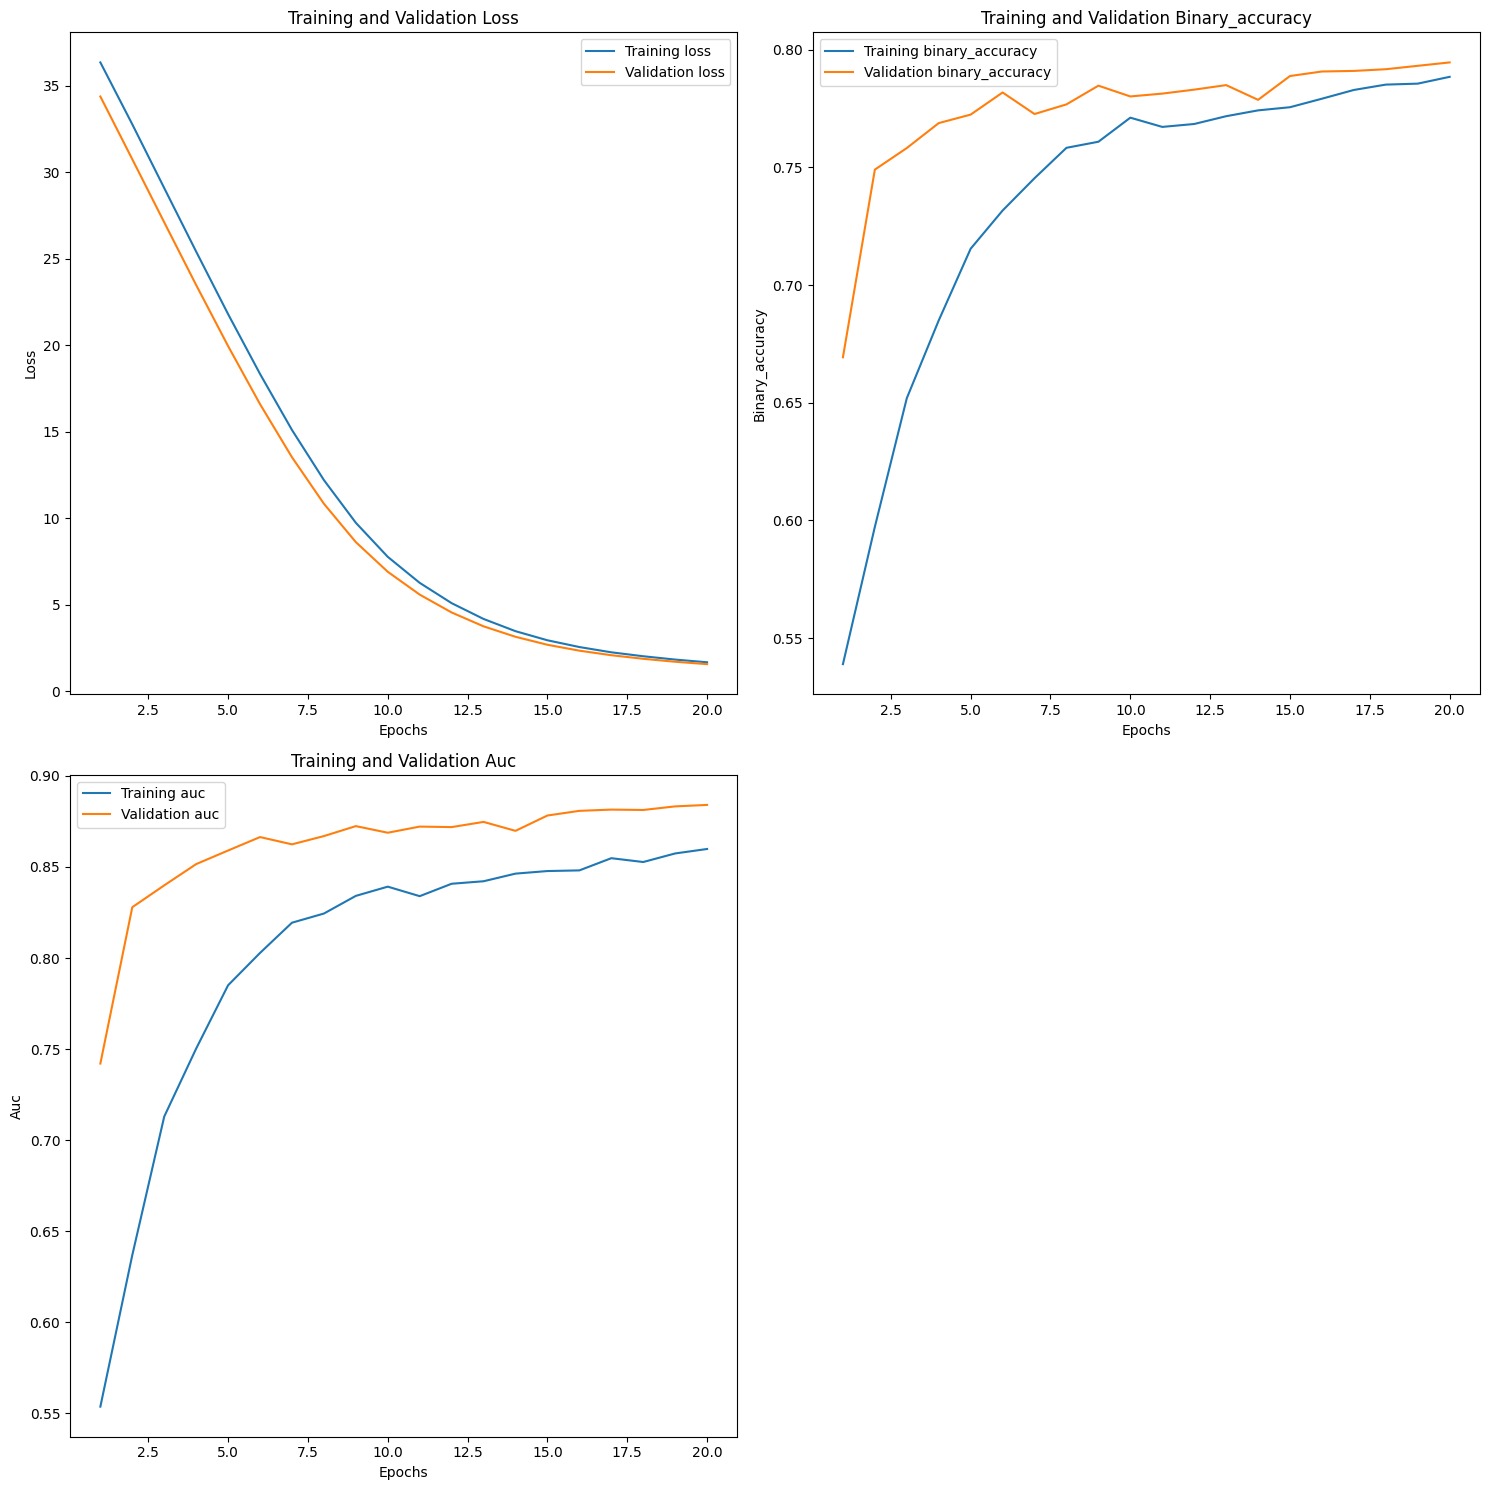

In [15]:
loud = 1
def create_and_plot_model():
    model = make_classification_model(num_scores_class)
    #clear_output()
    model.evaluate(X_val, y_val)
    #print(model.predict(X_train))
    #print(np.argmax(y_train, axis=1))
    history = model.fit(X_train, y_train, epochs=parameters['num_epochs'], batch_size=parameters['batch_size'], validation_data=(X_val, y_val), verbose=loud)
    print('\n2022-2023 Evaluation metrics:')
    model.evaluate(X_eval, y_eval)
    model.evaluate(X_val_2, y_val_2)
    metrics_to_plot = ['loss'] + [s.lower() if type(s) == str else s.name for s in metric_names]  
    plot_metrics(history.history, metrics_to_plot)
    return model
trained_model = create_and_plot_model()

In [16]:
import tensorflow as tf

def save_sequential_model(model, file_path):
    try:
        model.save(file_path)
        print("Model saved successfully to:", file_path)
    except Exception as e:
        print("Error while saving the model:", str(e))

def load_sequential_model(file_path):
    try:
        loaded_model = tf.keras.models.load_model(file_path)
        print("Model loaded successfully from:", file_path)
        return loaded_model
    except Exception as e:
        print("Error while loading the model:", str(e))
        return None


In [17]:
save_sequential_model(trained_model, './Models/binary_52_all.h5')

Model saved successfully to: ./Models/binary_52_all.h5


/home/quimbp/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
trained_model = load_sequential_model('./Models/binary_52.h5')

In [ ]:
@tf.function
def predict_with_dropout(model, inputs, n_samples=10):
  prediction_samples = []
  for i in range(n_samples):
    # Enable dropout at test time
    predictions = model(inputs, training=True)
    prediction_samples.append(predictions[:, 1])
  predictions = tf.reduce_mean(prediction_samples, axis=0)
  uncertainties = tf.math.reduce_std(prediction_samples, axis=0)
  return predictions, uncertainties

In [ ]:
add_on = '_srs'
def make_predictions(model):
    data = load_data(f'./Data/predictions/2023-09-27.pkl')
    minmax = load_data(f'./Dataset/MMScaler{add_on}.pkl')
    team_names = data[['Team_name', 'Op_name']]
    team_names.columns = ['Team_name', 'Op_name']
    data = data.drop(['Label', 'Date','Team_name', 'Op_name', 'Games', 'op_Games'], axis=1)
    scaled_data = pd.DataFrame(minmax.transform(data[columns_cur]))
    scaled_data.columns = columns_cur
    inputs = scaled_data[columns_cur]
    inputs = inputs.drop('Binary_Label', axis=1)
    predictions, uncertainties = predict_with_dropout(model, inputs)
    return team_names, predictions, uncertainties

In [ ]:
teams_pred, prediction, uncertainty = make_predictions(trained_model)
print([type(i) for i in uncertainty])
teams_pred = teams_pred.reset_index(drop=True)
#print(len([index for index, _ in teams_pred.iterrows()]))
#print(teams_pred)
all_names = teams_pred['Team_name'].to_list()
count = 1
rows = []
while len(all_names) > 0:
    name = all_names[0]
    idx = teams_pred[teams_pred['Team_name'] == name].index[0]
    opp = str(teams_pred['Op_name'][idx])
    opp_idx = teams_pred[teams_pred['Team_name'] == opp].index[0]
    name_pred = prediction[idx]
    name_unct = uncertainty[idx]
    opp_pred = prediction[opp_idx]
    opp_unct = uncertainty[opp_idx]
    #print(f'\tgame {count}: {name} VS. {opp}:')
    #print(f'{name}:{round(name_pred, 4)*100}% | {opp}: {round(opp_pred, 4)*100}%\n')
    rows.append([name, opp, name_pred, name_unct, opp_pred, opp_unct])
    all_names.remove(name)
    all_names.remove(opp)
    count += 1
new_preds_df = pd.DataFrame(rows)

In [ ]:
new_preds_df
#new_preds_df.to_csv('./Data/predictions/9-27-23_preds.csv', index=False)

In [ ]:
if False:
    y_pred_probabilities = trained_model.predict(X_train)
    y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
    y_true_classes = np.argmax(y_train, axis=1)
    print(y_pred_classes, y_true_classes)
    # Calculate training confusion matrix
    conf_mat_train = confusion_matrix(y_true_classes, y_pred_classes)

    # Predict on validation set
    y_pred_val = trained_model.predict(X_val) 
    y_pred_classes = np.argmax(y_pred_val, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)
    print(y_pred_classes.std(), y_true_classes.mean())
    # Calculate validation confusion matrix
    conf_mat_val = confusion_matrix(y_true_classes, y_pred_classes)


In [ ]:
if False:
    plt.figure(figsize=(10,5))

    plt.subplot(121)
    plt.title('Training Confusion Matrix')
    plt.imshow(conf_mat_train)
    plt.colorbar()
    plt.xlabel('Predicted Label')  
    plt.ylabel('True Label')

    plt.subplot(122)
    plt.title('Validation Confusion Matrix')
    plt.imshow(conf_mat_val)
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label') 

    plt.tight_layout()
    plt.show()

width_scale = 4
parameters = {
    'num_epochs': 10,
    'batch_size': 64,
    'learning_rate': 1e-4,
    'loss_fn': tf.keras.losses.Hinge,
    'drop_pct': 0.2,
    'starting_params': width_scale**4,
    'act_func': 'tanh',
    'num_layers': 8,
    'hidden_params': width_scale**5,
    'divisor': width_scale/2
}

70 %

In [ ]:
width_scale = 4
tracking_metrics = ['binary_accuracy', 'AUC', 'FalsePositives']
metric_names = ['binary_accuracy', 'auc', 'false_positives']
activations = [tf.keras.activations.tanh, tf.keras.activations.elu]
loss_fns = ['binary_crossentropy' , 'kl_divergence' , 'squared_hinge']
parameters = {
    'num_epochs': 15,
    'batch_size': 64,
    'learning_rate': 1e-5,
    'loss_fn': loss_fns[2],
    'drop_pct': 0.2,
    'starting_params': width_scale**4,
    'act_func': activations[1],
    'num_layers': 6,
    'hidden_params': width_scale**5,
    'divisor': width_scale/2
}

In [ ]:
def test_run():
    model = make_classification_model(num_scores_class)

    history = model.fit(X_train, y_train,
                        epochs=parameters['num_epochs'],
                        batch_size=parameters['batch_size'],
                        validation_data=(X_val, y_val),
                        verbose=0)
    result = model.evaluate(X_val, y_val)
    del model
    tf.keras.backend.clear_session()
    return result

In [ ]:
def itterate_var():
    losses = []
    test_vals = [x for x in range(0, 2)]
    for scaler in test_vals:
        #parameters['drop_pct'] = scaler/10  # - good values 0.2-0.5
        #parameters['learning_rate'] = 10**-scaler # 3 - 6
        #parameters['num_epochs'] = scaler # 5 - 20
        #parameters['batch_size'] = 2**(scaler) # 
        #parameters['num_layers'] = scaler 
        #parameters['loss_fn'] = loss_fns[scaler] # 0 - 2
        parameters['act_func'] = activations[scaler] # 0 - 1
        losses.append(test_run()[1])
    plot_arr(test_vals, losses)
    
itterate_var()

In [ ]:
import random

def random_search(params, num_iterations=10):
  accuracy_params = []
  for i in range(num_iterations):
    params['num_epochs'] = random.randint(5, 20)
    params['batch_size'] = 2**random.randint(5, 8) 
    params['learning_rate'] = 10**random.randint(-6, -3)
    params['loss_fn'] = random.choice(loss_fns)
    params['act_func'] = random.choice(activations)  
    params['drop_pct'] = random.uniform(0.2, 0.5)
    params_copy = params.copy()
    accuracy = test_run()[1]
    accuracy_params.append((accuracy, params_copy))
  accuracy_params.sort(key=lambda x: x[0], reverse=True)
  # Return top 3 accuracy and params
  top_accuracies = [x[0] for x in accuracy_params][:3]
  top_params = [x[1] for x in accuracy_params][:3]
  return top_accuracies, top_params

In [ ]:
top_accs, top_params = random_search(parameters, 50)
print(top_accs, top_params)

In [ ]:
def test_minibatch():

  evals = []

  batch_size = parameters['batch_size']  
  num_epochs = parameters['num_epochs']

  # Create an instance of your model
  with tf.device('/GPU:0'):
    model = make_model()

  # Get the total number of training samples
  num_samples = len(X_train)

  for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    for i in range(0, num_samples, batch_size):
      
      with tf.device('/GPU:0'):
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
      
      # Train the model on the current minibatch  
      with tf.device('/GPU:0'):
        model.train_on_batch(X_batch, y_batch)
        
      # Clear the GPU memory
      tf.keras.backend.clear_session()
      
      # Evaluate the model on the validation data
      with tf.device('/GPU:0'):  
        eval_metrics = model.evaluate(X_val, y_val)
        
      evals.append(eval_metrics[1])

  return evals

metrics_loss = test_minibatch()
plot_arr(metrics_loss)